Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

Begin Work - Feb 5, 2018 -mcliff

In [34]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [35]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


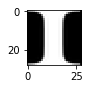

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
image = train_dataset[5234].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image,cmap="gray")
print(train_labels[5234])

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [36]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [37]:
def accuracy(predictions, labels):
  """expects predictions to be a object with ????
  """
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Modelling



Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

A Convolution,  takes an image and produces another image by appling a *weight* matrix to it (called the **kernel**) at each *point*, it then take a step (called *stride* to the next location).  In general if the stride is equal to 1 then the image is the *same* size (based on padding decisions it could be smaller). The weights of these convolution matrix are trained in the model, and essentially identify and help call out the **features** in the input data such as edges, or centers of mass.


In [42]:

# uses: 
#   image_size, num_channels, num_labels, train_labels
#  valid_dataset, test_dataset, # as consts 
def CN2Graph(batch_size=16, patch_size=5, depth=16, num_hidden=64,num_steps = 1001,
             display_step=50, verbose=False):
    """
    Creates a 2 Convolutional layer with one fully connected layer
    """

    #graph = tf.Graph()

    #with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    keep_prob = tf.placeholder(tf.float32) # DROP OUT here 
  
    # Variables
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

        
    # input is a 4d tensor - [batches, width, height, channel==1]    
    # Model
    def model(data):
        # stride of 2 means we reduce the next layer to 14x14  (we have x16 for depth)
        # input is data-16x28x28x1 ;  w1 - 5x5x1x16 [Hgt,Wght,In-Chan,Out-Chan]
        #   output is 16x14x14x16;  b1 is 16x1 (one for each of the depth on convultion)
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        # again a stride of 2 reduces us to 7x7, and now we have 16 channels for each depth layer
        # hidden is 16x14x14x16   ;   w2 is 5x5x16x16; b2 is 16x1
        #   output is 16x7x7x16
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        #  reshape now to 16x784    basically push all the layers and pixels into a giant list
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        # w3 is 784x64, b3 is 64x1  (standard fully connected)
        # hidden is 16x64
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        # w4 is 64x10, b4 is 10x1; result here is 16x1 these are the logit numbers
        return tf.matmul(hidden, layer4_weights) + layer4_biases
        
    logits = model(tf_train_dataset)
        
    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
        
        
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        retAcc = []
        for step in range(num_steps):
            # on each step pull a different subset
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # what is train_labels.shape[0] ?
            batch_data = train_dataset[offset:(offset+batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            
            # this is what we actually feed into the graph above
            feed_dict = {
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
            # local vars l and preductions get returned from graph variables 'loss' and 'train_prediction'
            #    'optimizer' is also evaluated in the graph
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict
            )
            
            if (step % display_step == 0):
                if verbose:
                    print('Accuracy (Batch/Validation): %5.1f%% %5.1f%%\tloss at step %d: %f' % 
                          (accuracy(predictions, batch_labels),
                           accuracy(valid_prediction.eval(), valid_labels),
                           step, l))
                retAcc.append(accuracy(valid_prediction.eval(), valid_labels))
                
            
    return(retAcc)
    

In [43]:
CN2Graph()

[9.8300000000000001,
 68.349999999999994,
 73.980000000000004,
 76.239999999999995,
 78.209999999999994,
 78.469999999999999,
 80.030000000000001,
 77.739999999999995,
 80.030000000000001,
 79.329999999999998,
 81.659999999999997,
 81.090000000000003,
 82.469999999999999,
 82.659999999999997,
 82.920000000000002,
 83.390000000000001,
 83.019999999999996,
 82.799999999999997,
 83.760000000000005,
 83.609999999999999,
 82.909999999999997]

In [44]:

# uses: 
#   image_size, num_channels, num_labels, train_labels
#  valid_dataset, # as consts 
def ModelCNN(batch_size=16, patch_size=5, depth=16, num_hidden=64, 
              num_steps = 1001, display_step=50, verbose=False):
    """
    Creates a 2 Convolutional layer with one fully connected layer
    """

    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(test_dataset)
        keep_prob = tf.placeholder(tf.float32) # DROP OUT here 
  
        # Variables
        layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
        
        layer1_biases = tf.Variable(tf.zeros([depth]))
    
        layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth], stddev=0.1))
        layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
        layer3_weights = tf.Variable(tf.truncated_normal(
          [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
        layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
        layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
        layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

        
        
        # Model
        def model(data):
            # 
            conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer1_biases)
            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer2_biases)
            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
            return tf.matmul(hidden, layer4_weights) + layer4_biases
        
        logits = model(tf_train_dataset)
        
        # Training computation.
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        #test_prediction = tf.nn.softmax(model(tf_test_dataset))
        
        
    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())

        retAcc = []
        for step in range(num_steps):
            # on each step pull a different subset
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # what is train_labels.shape[0] ?
            batch_data = train_dataset[offset:(offset+batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            
            # this is what we actually feed into the graph above
            feed_dict = {
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
            # local vars l and preductions get returned from graph variables 'loss' and 'train_prediction'
            #    'optimizer' is also evaluated in the graph
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict
            )
            
            if (step % display_step == 0):
                if verbose:
                    print('Accuracy (Batch/Validation): %5.1f%% %5.1f%%\tloss at step %d: %f' % 
                          (accuracy(predictions, batch_labels),
                           accuracy(valid_prediction.eval(), valid_labels),
                           step, l))
                retAcc.append(accuracy(valid_prediction.eval(), valid_labels))

            
    return(retAcc)
    

In [45]:
cnn = ModelCNN(num_steps=1001, display_step=50)
cnn

In [46]:
cnn

[9.3900000000000006,
 65.560000000000002,
 73.530000000000001,
 76.180000000000007,
 77.689999999999998,
 78.359999999999999,
 79.390000000000001,
 76.629999999999995,
 80.400000000000006,
 79.780000000000001,
 80.719999999999999,
 81.379999999999995,
 82.0,
 81.790000000000006,
 82.480000000000004,
 82.840000000000003,
 83.040000000000006,
 82.700000000000003,
 82.930000000000007,
 83.010000000000005,
 82.219999999999999]

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

Side Note: per this article we should never use sigmoids because they "saturate and die"
http://cs231n.github.io/neural-networks-1/

In [47]:

# uses: 
#   image_size, num_channels, num_labels, train_labels
#  valid_dataset, test_dataset, # as consts 
#
# patch_size - 2*kernel_size + 1;  used for convolution
#
def MaxPoolModel(batch_size=16, patch_size=5, depth=16, num_hidden=64,
                 validation_dataset=valid_dataset, verbose=True, 
                 display_step=50, num_steps = 1001):
    """
    Creates a 2 Convolutional layer with one fully connected layer
    """

    #graph = tf.Graph()

    #with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(validation_dataset)
    keep_prob = tf.placeholder(tf.float32) # DROP OUT here 
  
    # Variables
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

        
        
    # Model
    def model(data):
        # input 16x28x28x1; output is 16x28x28x16
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        # input is 16x28x28x16, output is 16x14x14x16
        max_reduce = tf.nn.max_pool(conv, [1,2,2,1], [1, 2, 2, 1], padding='SAME')       
        # l1 is 16x1
        hidden = tf.nn.relu(max_reduce + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')

        max_reduce = tf.nn.max_pool(conv, [1,2,2,1], [1, 2, 2, 1], padding='SAME')       
        

        hidden = tf.nn.relu(max_reduce + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
        
    logits = model(tf_train_dataset)
        
    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        


    retAcc = []
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        
        for step in range(num_steps):
            # on each step pull a different subset
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # what is train_labels.shape[0] ?
            batch_data = train_dataset[offset:(offset+batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            
            # this is what we actually feed into the graph above
            feed_dict = {
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
            # local vars l and preductions get returned from graph variables 'loss' and 'train_prediction'
            #    'optimizer' is also evaluated in the graph
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict
            )
            
            if (step % display_step == 0):
                if verbose:
                    print('Accuracy (Batch/Validation): %5.1f%% %5.1f%%\tloss at step %d: %f' % 
                          (accuracy(predictions, batch_labels),
                           accuracy(valid_prediction.eval(), valid_labels),
                           step, l))                
            
                retAcc.append(accuracy(valid_prediction.eval(), valid_labels))

            
    return(retAcc)         
    

In [48]:
pool = MaxPoolModel(num_steps=1001, display_step=50, verbose=False)
pool

[8.9399999999999995,
 54.990000000000002,
 70.890000000000001,
 76.010000000000005,
 79.349999999999994,
 77.010000000000005,
 80.670000000000002,
 79.879999999999995,
 81.430000000000007,
 80.519999999999996,
 82.379999999999995,
 81.950000000000003,
 82.959999999999994,
 83.140000000000001,
 83.950000000000003,
 84.129999999999995,
 84.180000000000007,
 82.829999999999998,
 84.200000000000003,
 84.239999999999995,
 84.049999999999997]

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

reference [LeNet in TensorFlow](https://github.com/sujaybabruwad/LeNet-in-Tensorflow)

**Specs**

- Input Image is 28x28x1 and converted to 32x32x1 as per LeNet requirements.
- Convolution layer 1: The output shape should be 28x28x6.
- Activation 1: Your choice of activation function.
- Pooling layer 1: The output shape should be 14x14x6.
- Convolution layer 2: The output shape should be 10x10x16.
- Activation 2: Your choice of activation function.
- Pooling layer 2: The output shape should be 5x5x16.
- Flatten layer: Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.
- Fully connected layer 1: This should have 120 outputs.
- Activation 3: Your choice of activation function.
- Fully connected layer 2: This should have 10 outputs.
- Return the result of the 2nd fully connected layer from the LeNet function.

---

In [49]:
### TODO put my new model here

def GraphLeNet5(x):
    """
    Input a 4D tensor;
    Output 4D tensor to use for Logit in Loss optimization
    """
    # used for sedding weights and bias
    mu = 0
    sigma = 0.1
    
    # layer1 - convolution (we should use VALID padding and got 32x32 - 28x28; 
    #    since we have 28x28 input use SAME padding)
    #   6 depth layers, and 2 dimension kernel (5x5 filter)
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5,5,1,6], mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='SAME')
    
    # now run the activation function
    # output is Nx28x28x6
    conv1 = tf.nn.relu(conv1 + conv1_b)
    


    fc2 = fc3_w = fc3_b = 0;
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits




def ModelLeNet5(batch_size=16, patch_size=5, depth=16, num_hidden=64,
                 validation_dataset=valid_dataset, verbose=True, 
                 display_step=50, num_steps = 1001):    

    
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, 10)

        # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(validation_dataset)

    
    rate = 0.001
    logits = LogitLeNet5(tf_train_datset)

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(tf_train_labels,1))
    
    def evaluate(X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):  # BATCH_SIZE=16
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(ac)
            

NameError: name 'graph' is not defined